
# Assignment 1: Exploring Word Embeddings
**Course Name:** Natural Language Processing (CSC6052/5051/4100/DDA6307/MDS5110)





*Please enter your personal information (make sure you have copied this colab)*

**Name:** Zijin CAI

**Student ID:** 224040002






## Assignment Requirements

This Colab file includes all contents for Assignment 1.

#### You are required to:

1. **Make a copy of the provided Google Colab file.**  
   First, you need to make a copy of the provided file into your own Google Drive. To accomplish this, open the Colab file link, navigate to `File` → `Save a copy in Drive`.

2. **Execute the notebook to generate results.**  
   You can click on "Connect to GPU" to apply for a free T4 GPU. Then, you can press the large play button to run a code cell.

3. **Complete the Necessary Parts.**  
   Some sections of the code are incomplete and require your input, especially pay attention to the parts marked with **<font color="red">[Task]</font>**. These sections are critical for scoring the assignment.

For more detailed instructions, refer to [Working with Google Colab](https://docs.google.com/document/d/1vMe8kC-oSyP3w7rIurDbG3NqfyQw7sZJ2C_S2ngtQnk/edit?usp=sharing).

## Submission Guidelines

Follow these steps to submit your assignment:

1. **Export the Notebook:** Navigate to `File` → `Download .ipynb` to download your notebook.

2. **Upload Your File:** Access the [Blackboard system](https://bb.cuhk.edu.cn/) and upload your `.ipynb` file.


## Overview

*Assignment 1* consists of two tasks:
- Task 1: Train Word Embeddings with Word2Vec (5 points)
- Task 2: Explore word embeddings (3 ponits)
- Task 3: Utilize word embeddings (2 points)

Your task is to **run all the code in this script** and complete the parts marked with <font color="red">[task]</font>.

## Prerequisite
If you're new to Python, Numpy, or PyTorch, consider these tutorials for a quick start:
- [Python-Numpy-Tutorial](https://cs231n.github.io/python-numpy-tutorial/)
- [Introduction to PyTorch](https://colab.research.google.com/drive/1obAmmGHsMizB38aiZJ_-L1bVMT5KOLMd?usp=sharing)

## Task 1: Train Word Embeddings with Word2Vec

**In this task, you will implement and train your own Word2Vec model.**

Before diving in, let's clarify what Word2Vec is.

Its core concept is straightforward: you can infer the meaning of a word from its neighbors - the words that frequently appear in the same context. Consider this illustration:
![Contexts](https://image.ibb.co/mnQ2uz/2018_09_17_21_07_08.png)

A basic approach is to use the context word counts as meaningful word vectors. Take this simple corpus for example:

```
The red fox jumped
The brown fox jumped
```

The count vectors would look like this:
```
        the fox jumped red brown
red   = (1   1    1     0    0)
brown = (1   1    1     0    0)
```

Notice how `red` and `brown` have similar vectors! We're close to solving the problem, but the goal is to obtain more compact embedding vectors.

This is where Word2Vec algorithms come into play. They construct embedding vectors based on the word's neighbors in the corpus.

For a more detailed introduction, check out this post: [king - man + woman = queen; but why?](http://p.migdal.pl/2017/01/06/king-man-woman-queen-why.html).

Let's do some preparation work before moving to the interesting stuff.



### **1.1 Preparation**

Environment installation and data download

 !pip3 -qq install torch==1.1

!pip -qq install nltk==3.2.5

!pip -qq install gensim

!pip -qq install bokeh==3.2.0

!wget -O quora.zip -qq --no-check-certificate "https://drive.google.com/uc?export=download&id=1ERtxpdWOgGQ3HOigqAMHTJjmOE_tWvoF"

!unzip -o quora.zip

In [1]:
import os

import nltk
import time
import math
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from IPython.display import clear_output
%matplotlib inline
np.random.seed(42)

import pandas as pd
from nltk.tokenize import word_tokenize
from tqdm import tqdm


In [2]:
nltk.download('punkt_tab', download_dir='/home/cai/Task/CUHKSZ/MSc Data Science/Year 1/Term 2/MDS5110-Natural Language Processing/Assignment 1')
nltk.data.path.append('/home/cai/Task/CUHKSZ/MSc Data Science/Year 1/Term 2/MDS5110-Natural Language Processing/Assignment 1')

nltk.data.find('tokenizers/punkt')

[nltk_data] Downloading package punkt_tab to /home/cai/Task/CUHKSZ/MSc
[nltk_data]     Data Science/Year 1/Term 2/MDS5110-Natural Language
[nltk_data]     Processing/Assignment 1...
[nltk_data]   Package punkt_tab is already up-to-date!


FileSystemPathPointer('/home/cai/Task/CUHKSZ/MSc Data Science/Year 1/Term 2/MDS5110-Natural Language Processing/Assignment 1/tokenizers/punkt')

1. Tokenize and lower-case texts.

In [3]:
quora_data = pd.read_csv('train.csv')

quora_data.question1 = quora_data.question1.replace(np.nan, '', regex=True)
quora_data.question2 = quora_data.question2.replace(np.nan, '', regex=True)

texts = list(pd.concat([quora_data.question1, quora_data.question2]).unique())
texts = texts[:50000] # Accelerated operation
print(len(texts))

tokenized_texts = [word_tokenize(text.lower()) for text in tqdm(texts)]

assert len(tokenized_texts) == len(texts)
assert isinstance(tokenized_texts[0], list)
assert isinstance(tokenized_texts[0][0], str)

50000


100%|██████████| 50000/50000 [00:01<00:00, 28476.27it/s]


In [4]:
tokenized_texts[0]

['what',
 'is',
 'the',
 'step',
 'by',
 'step',
 'guide',
 'to',
 'invest',
 'in',
 'share',
 'market',
 'in',
 'india',
 '?']

2. Collect the indices of the words:

In [5]:
from collections import Counter

MIN_COUNT = 5

words_counter = Counter(token for tokens in tokenized_texts for token in tokens)
word2index = {
    '<unk>': 0
}

for word, count in words_counter.most_common():
    if count < MIN_COUNT:
        break

    word2index[word] = len(word2index)

index2word = [word for word, _ in sorted(word2index.items(), key=lambda x: x[1])]

print('Vocabulary size:', len(word2index))
print('Tokens count:', sum(len(tokens) for tokens in tokenized_texts))
print('Unknown tokens appeared:', sum(1 for tokens in tokenized_texts for token in tokens if token not in word2index))
print('Most freq words:', index2word[1:21])

Vocabulary size: 7226
Tokens count: 623563
Unknown tokens appeared: 35607
Most freq words: ['?', 'the', 'what', 'is', 'how', 'i', 'a', 'to', 'in', 'do', 'of', 'are', 'and', 'can', 'for', ',', 'you', 'why', 'it', 'best']


3. collect the context words

First of all, we need to collect all the contexts from our corpus.

In [6]:
def build_contexts(tokenized_texts, window_size):
    contexts = []
    for tokens in tokenized_texts:
        for i in range(len(tokens)):
            central_word = tokens[i]
            context = [tokens[i + delta] for delta in range(-window_size, window_size + 1)
                       if delta != 0 and i + delta >= 0 and i + delta < len(tokens)]

            contexts.append((central_word, context))

    return contexts

contexts = build_contexts(tokenized_texts, window_size=2)

Check, what you got:

In [7]:
contexts[:5]

[('what', ['is', 'the']),
 ('is', ['what', 'the', 'step']),
 ('the', ['what', 'is', 'step', 'by']),
 ('step', ['is', 'the', 'by', 'step']),
 ('by', ['the', 'step', 'step', 'guide'])]

4. Convert to indices

Let's convert words to indices:

In [8]:
contexts = [(word2index.get(central_word, 0), [word2index.get(word, 0) for word in context])
            for central_word, context in contexts]

### **1.2 Continuous Bag of Words (CBoW) Word2vec**

We have learn skip-gram model in tutorial. Now, we will explore another popular Word2Vec paradigm called Continuous Bag of Words (CBoW). *CBoW* offers faster processing and slightly better accuracy for common words compared to the *Skip-Gram*, which is more effective with rare words.

**CBoW Structure**

Below is the CBoW model architecture:

![](https://i.ibb.co/StXTMFH/CBOW.png)

In CBoW, the goal is to predict a target word from its surrounding context, represented by the sum of context vectors.

We will leverage our understanding from the *Skip-Gram* model to implement *CBoW*.

1. **Batches Generations**
**<font color="red">[Task]</font>** : Implement the batch generator.

**Hint**: The generator should produce a input matrix `(batch_size, 2 * window_size)` containing context word indices and a target matrix `(batch_size)` with central word indices.

In [9]:
def make_cbow_batches_iter(contexts, window_size, batch_size):

    central_words = np.array([word for word, context in contexts if len(context) == 2 * window_size and word != 0])
    contexts = np.array([context for word, context in contexts if len(context) == 2 * window_size and word != 0])


    batches_count = int(math.ceil(len(contexts) / batch_size))

    print('Initializing batches generator with {} batches per epoch'.format(batches_count))

    indices = np.arange(len(contexts))
    np.random.shuffle(indices)

    for i in range(batches_count):
      batch_begin, batch_end = i * batch_size, min((i + 1) * batch_size, len(contexts))
      batch_indices = indices[batch_begin: batch_end]
      
      batch_contexts = contexts[batch_indices]
      batch_targets = central_words[batch_indices]
      
      yield {
            'tokens': torch.LongTensor(batch_contexts),
            'labels': torch.LongTensor(batch_targets)
        }

Check it:

In [10]:
window_size = 2
batch_size = 32

batch = next(make_cbow_batches_iter(contexts, window_size=window_size, batch_size=batch_size))

assert isinstance(batch, dict)
assert 'labels' in batch and 'tokens' in batch

assert isinstance(batch['tokens'], torch.LongTensor)
assert isinstance(batch['labels'], torch.LongTensor)

assert batch['tokens'].shape == (batch_size, 2 * window_size)
assert batch['labels'].shape == (batch_size,)

Initializing batches generator with 12380 batches per epoch


2. **Model**
**<font color="red">[Task]</font>**: Build the `CBoWModel`.

**Hint**: You need to implement the `forward` method based on the CBoW architecture. The context embedding is represented as the average of their context embeddings.

In [11]:
class CBoWModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super().__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.out_layer = nn.Linear(embedding_dim, vocab_size)

    def forward(self, inputs):
        context_embeddings = self.embeddings(inputs)
        context_avg = torch.mean(context_embeddings, dim=1)
        output = self.out_layer(context_avg)
        
        return output

Check it:

In [12]:
model = CBoWModel(vocab_size=len(word2index), embedding_dim=32).cuda()

outputs = model(batch['tokens'].cuda())

assert isinstance(outputs, torch.cuda.FloatTensor)
assert outputs.shape == (batch_size, len(word2index))

3. **Training**
**<font color="red">[Task]</font>** : Train the CBoW.

**Hint**: Consider referring to the training code of the previously mentioned *Skip-gram* model.

In [13]:
# Here are the hyperparameters you can adjust
embedding_dim = 32
learning_rate = 0.001
epoch_num = 4
batch_size = 128

# Initialization Model
model = CBoWModel(len(word2index),embedding_dim)
# Getting model to GPU
model.cuda()
# Define the loss function
criterion = nn.CrossEntropyLoss()
# use Adam optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

loss_every_nsteps = 3000
total_loss = 0
start_time = time.time()
global_step = 0

for ep in range(epoch_num):
  for step, batch in enumerate(make_cbow_batches_iter(contexts, window_size=2, batch_size=batch_size)):
      global_step += 1
      
      # move batch to GPU
      inputs = batch['tokens'].cuda()
      labels = batch['labels'].cuda()
      
      # zero the gradients
      optimizer.zero_grad()
      
      # forward pass
      outputs = model(inputs)
      
      # compute the loss
      loss = criterion(outputs, labels)
      
      # backward pass and optimize
      loss.backward()
      optimizer.step()

      total_loss += loss.item()

      if global_step != 0 and global_step % loss_every_nsteps == 0:
          print("Epoch = {}, Step = {}, Avg Loss = {:.4f}, Time = {:.2f}s".format(ep, step, total_loss / loss_every_nsteps,
                                                                      time.time() - start_time))
          total_loss = 0
          start_time = time.time()

Initializing batches generator with 3095 batches per epoch
Epoch = 0, Step = 2999, Avg Loss = 6.4985, Time = 1.58s
Initializing batches generator with 3095 batches per epoch
Epoch = 1, Step = 2904, Avg Loss = 5.5577, Time = 1.23s
Initializing batches generator with 3095 batches per epoch
Epoch = 2, Step = 2809, Avg Loss = 5.2459, Time = 1.27s
Initializing batches generator with 3095 batches per epoch
Epoch = 3, Step = 2714, Avg Loss = 5.0518, Time = 1.29s


**Obtaining word embeddings**

Word embeddings are contained within the embeddings layer of the model. We just need to move them from the GPU to the CPU and convert them to a numpy array.

In [14]:
embeddings = model.embeddings.weight.data.cpu().numpy()

**Testing Trained Word Embeddings**

Let's check how adequate are similarities that the model learnt.

In [16]:
from sklearn.metrics.pairwise import cosine_similarity

def most_similar(embeddings, index2word, word2index, word):
    word_emb = embeddings[word2index[word]]

    similarities = cosine_similarity([word_emb], embeddings)[0]
    top10 = np.argsort(similarities)[-10:]

    return [index2word[index] for index in reversed(top10)]

most_similar(embeddings, index2word, word2index, 'my')

['my',
 'skype',
 'our',
 'luther',
 'jio',
 'papua',
 'swedish',
 'volte',
 'gene',
 'easy']

**Visualization of our embeddings**

In [17]:
import bokeh.models as bm, bokeh.plotting as pl
from bokeh.io import output_notebook

from sklearn.manifold import TSNE
from sklearn.preprocessing import scale


def draw_vectors(x, y, radius=10, alpha=0.25, color='blue',
                 width=600, height=400, show=True, **kwargs):
    """ draws an interactive plot for data points with auxilirary info on hover """
    output_notebook()

    if isinstance(color, str):
        color = [color] * len(x)
    data_source = bm.ColumnDataSource({ 'x' : x, 'y' : y, 'color': color, **kwargs })

    fig = pl.figure(active_scroll='wheel_zoom', width=width, height=height)
    fig.scatter('x', 'y', size=radius, color='color', alpha=alpha, source=data_source)

    fig.add_tools(bm.HoverTool(tooltips=[(key, "@" + key) for key in kwargs.keys()]))
    if show:
        pl.show(fig)
    return fig


def get_tsne_projection(word_vectors):
    tsne = TSNE(n_components=2, verbose=1)
    return scale(tsne.fit_transform(word_vectors))


def visualize_embeddings(embeddings, index2word, word_count):
    word_vectors = embeddings[1: word_count + 1]
    words = index2word[1: word_count + 1]

    word_tsne = get_tsne_projection(word_vectors)
    draw_vectors(word_tsne[:, 0], word_tsne[:, 1], color='blue', token=words)


visualize_embeddings(embeddings, index2word, 100)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 100 samples in 0.000s...
[t-SNE] Computed neighbors for 100 samples in 0.049s...
[t-SNE] Computed conditional probabilities for sample 100 / 100
[t-SNE] Mean sigma: 4.135942
[t-SNE] KL divergence after 250 iterations with early exaggeration: 69.047462
[t-SNE] KL divergence after 1000 iterations: 0.630234


/home/cai/anaconda3/envs/torch1/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:258: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/home/cai/anaconda3/envs/torch1/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:277: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(


Loading BokehJS ...

In [18]:
def get_tane_projection(word_vectors):
    # MinMaxScaler to pre-scale the data
    scaler = MinMaxScaler()
    word_vectors_scaled = scaler.fit_transform(word_vectors)
    
    tsne = TSNE(n_components=2, verbose=1)
    tsne_projection = tsne.fit_transform(word_vectors_scaled)
    
    return scale(tsne_projection)

visualize_embeddings(embeddings, index2word, 100)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 100 samples in 0.000s...
[t-SNE] Computed neighbors for 100 samples in 0.006s...
[t-SNE] Computed conditional probabilities for sample 100 / 100
[t-SNE] Mean sigma: 4.135942
[t-SNE] KL divergence after 250 iterations with early exaggeration: 74.583382
[t-SNE] KL divergence after 1000 iterations: 0.606368


/home/cai/anaconda3/envs/torch1/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:258: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/home/cai/anaconda3/envs/torch1/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:277: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(


Loading BokehJS ...

## Task 2： Explore Word Embeddings with Word2Vec
In this task, we shall explore the embeddings produced by word2vec. Please revisit the lecture slides or tutorials for more details on the word2vec algorithm. If you're feeling adventurous, challenge yourself and try reading the original [paper](https://proceedings.neurips.cc/paper_files/paper/2013/file/9aa42b31882ec039965f3c4923ce901b-Paper.pdf).

Then run the following cells to load the word2vec vectors into memory. **Note**: This might take several minutes.

In [29]:
import os
os.environ['GENSIM_DATA_DIR'] = '/home/cai/Task/CUHKSZ/MSc Data Science/Year 1/Term 2/MDS5110-Natural Language Processing/Assignment 1'

def load_word2vec():
    """ Load GloVe Twitter Vectors
        Return:
            wv_from_bin: Pre-trained embeddings with 25 dimensions for 1.2M vocabulary.
    """
    import gensim.downloader as api
    wv_from_bin = api.load("glove-twitter-25")
    vocab = list(wv_from_bin.key_to_index.keys())  # Updated for Gensim 4.x
    print("Loaded vocab size %i" % len(vocab))
    return wv_from_bin

In [30]:
# -----------------------------------
# Run Cell to Load Word Vectors
# Note: This may take several minutes
# -----------------------------------
wv_from_bin = load_word2vec()

Loaded vocab size 1193514



**Reducing dimensionality of Word2Vec Word Embeddings**

Let's directly compare the word2vec embeddings to those of the co-occurrence matrix. Run the following cells to:

- Put the 1.2 million word2vec vectors into a matrix M
- Run reduce_to_k_dim (your Truncated SVD function) to reduce the vectors from 25-dimensional to 2-dimensional.



In [34]:
def get_matrix_of_vectors(wv_from_bin, required_words=['barrels', 'bpd', 'ecuador', 'energy', 'industry', 'kuwait', 'oil', 'output', 'petroleum', 'venezuela']):
    """ Put the word2vec vectors into a matrix M.
        Param:
            wv_from_bin: KeyedVectors object; the 1.2 million word2vec vectors loaded from file
        Return:
            M: numpy matrix shape (num words, 300) containing the vectors
            word2Ind: dictionary mapping each word to its row number in M
    """
    import random
    words = list(wv_from_bin.key_to_index.keys())
    print("Shuffling words ...")
    random.shuffle(words)
    words = words[:10000]
    print("Putting %i words into word2Ind and matrix M..." % len(words))
    word2Ind = {}
    M = []
    curInd = 0
    for w in words:
        try:
            M.append(wv_from_bin.get_vector(w))
            word2Ind[w] = curInd
            curInd += 1
        except KeyError:
            continue
    for w in required_words:
        try:
            M.append(wv_from_bin.get_vector(w))
            word2Ind[w] = curInd
            curInd += 1
        except KeyError:
            continue
    M = np.stack(M)
    print("Done.")
    return M, word2Ind

**Implement reduce_to_k_dim**

Construct a method that performs dimensionality reduction on the matrix to produce k-dimensional embeddings. Use SVD to take the top k components and produce a new matrix of k-dimensional embeddings.

Note: All of numpy, scipy, and scikit-learn (sklearn) provide some implementation of SVD, but only scipy and sklearn provide an implementation of Truncated SVD, and only sklearn provides an efficient randomized algorithm for calculating large-scale Truncated SVD. So please use [sklearn.decomposition.TruncatedSVD](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html).

**<font color="red">[Task]</font>**: Complete reduce_to_k_dim function

In [35]:
from sklearn.decomposition import TruncatedSVD

def reduce_to_k_dim(M, k=2):
    """ Reduce a co-occurence count matrix of dimensionality (num_corpus_words, num_corpus_words)
        to a matrix of dimensionality (num_corpus_words, k) using the following SVD function from Scikit-Learn:
            - http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html

        Params:
            M (numpy matrix of shape (number of corpus words, number of corpus words)): co-occurence matrix of word counts
            k (int): embedding size of each word after dimension reduction
        Return:
            M_reduced (numpy matrix of shape (number of corpus words, k)): matrix of k-dimensioal word embeddings.
                    In terms of the SVD from math class, this actually returns U * S
    """
    n_iters = 10     # Use this parameter in your call to `TruncatedSVD`
    print("Running Truncated SVD over %i words..." % (M.shape[0]))
    
    # initialize the truncated SVD
    svd = TruncatedSVD(n_components=k, n_iter=n_iters, random_state=42)
    
    # fit the model and transform the data
    M_reduced = svd.fit_transform(M)

    print("Done.")
    return M_reduced

In [36]:
# -----------------------------------------------------------------
# Run Cell to Reduce 25-Dimensinal Word Embeddings to k Dimensions
# Note: This may take several minutes
# -----------------------------------------------------------------
M, word2Ind = get_matrix_of_vectors(wv_from_bin)
M_reduced = reduce_to_k_dim(M, k=2)

Shuffling words ...
Putting 10000 words into word2Ind and matrix M...
Done.
Running Truncated SVD over 10010 words...
Done.


**Here is a helper function to plot a set of 2D vectors in 2D space. For graphs, we will use Matplotlib (plt).**

In [37]:
import matplotlib.pyplot as plt

def plot_embeddings(M_reduced, word2Ind, words):
    """ Plot in a scatterplot the embeddings of the words specified in the list "words".
        Include a label next to each point.

        Params:
            M_reduced (numpy matrix of shape (number of unique words in the corpus, k)): matrix of k-dimensional word embeddings
            word2Ind (dict): dictionary that maps word to indices for matrix M
            words (list of strings): words whose embeddings we want to visualize
    """
    plt.figure(figsize=(10, 10))
    for word in words:
        if word in word2Ind:
            idx = word2Ind[word]
            x, y = M_reduced[idx, 0], M_reduced[idx, 1]
            plt.scatter(x, y, marker='o', color='blue')
            plt.text(x + 0.02, y + 0.02, word, fontsize=9)
        else:
            print(f"Word '{word}' not found in word2Ind dictionary.")

    plt.title("Word Embeddings Visualization")
    plt.xlabel("Dimension 1")
    plt.ylabel("Dimension 2")
    plt.grid(True)
    plt.show()

### 2.1: Word2Vec Plot Analysis
Run the cell below to plot the 2D word2vec embeddings for ['barrels', 'bpd', 'ecuador', 'energy', 'industry', 'kuwait', 'oil', 'output', 'petroleum', 'venezuela'].

What clusters together in 2-dimensional embedding space? What doesn't cluster together that you might think should have? How is the plot different from the one generated earlier from the co-occurrence matrix?

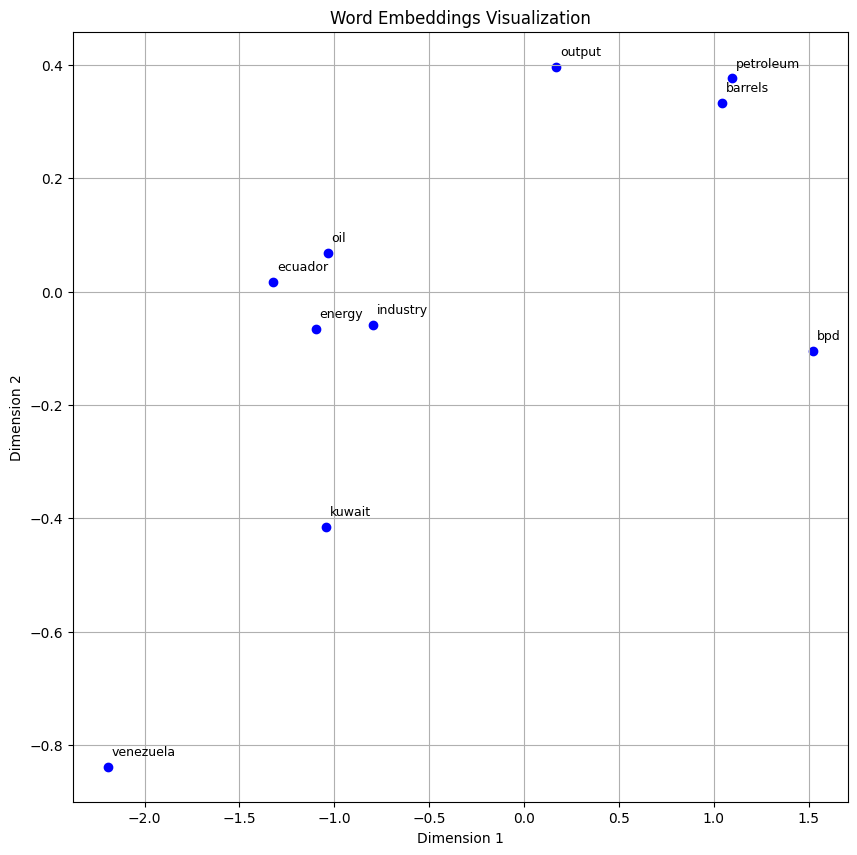

In [38]:
words = ['barrels', 'bpd', 'ecuador', 'energy', 'industry', 'kuwait', 'oil', 'output', 'petroleum', 'venezuela']
plot_embeddings(M_reduced, word2Ind, words)

**<font color="red">[Task]</font>**:Write your answer here.

- The words "oil", "ecuador", "energy" and "industry" are clustered together in the 2-dimensional embedding space, 
    - this might due to the fact that ecuador is a country that produces oil, and oil is a type of energy that is produced by the industry.  
- The words "petroleum" and "barrels" are also clustered together, 
    - which makes sense because petroleum is stored in barrels.

- The words "kuwait" and "venezuela" are not clustered together, neither close to any "industry" nor "petroleum" clusters,
    - which is surprising because both are countries that produce oil.
    - This might suggest the embeddings are more focused on the geographical aspect rather than their role in the industry.
- The word "output" is detached from the other words, which is also unexpected because it is related to the industry.
    - However, the contextual usage of the word "output" might be different from the other words in the list, which could explain the separation.
- It is also unexpected that the words "petroleum", "barrels" and "oil" are not clustered together, as they are closely related in meaning.
    - This can be attributed to the fact that the embeddings are based on the context in which the words appear rather than their meaning,
    - as the "petroleum" is used more in technical contexts and "oil" can be used in a broader everyday context.

**Difference from the co-occurrence matrix:**
1. **Word2Vec Embeddings**: 
The Word2Vec embeddings typically capture the semantic meaning of words based on their context in the corpus. 
    Words that are semantically similar but do not occur frequently might still be close in the Word2Vec plot.
2. **Dimensionality**:
The Word2Vec embeddings are reduced to a lower dimension (e.g., 2D) for visualization, 
    which may lead to some loss of information compared to the more sparse co-occurrence matrix.
3. **Contextual Relationships**:
Word2Vec embeddings can capture broader contextual relationships, whereas co-occurrence matrices are more focused on direct word associations.
    This can result in different clustering patterns, with Word2Vec embeddings reflecting more semantic relationships.


### 2.2 Polysemous Words
Find a [polysemous](https://en.wikipedia.org/wiki/Polysemy) word (for example, "leaves" or "scoop") such that the top-10 most similar words (according to cosine similarity) contains related words from both meanings. For example, "leaves" has both "turns" and "ground" in the top 10, and "scoop" has both "buckets" and "pops". You will probably need to try several polysemous words before you find one. Please state the polysemous word you discover and the multiple meanings that occur in the top 10. Why do you think many of the polysemous words you tried didn't work?

Note: You should use the wv_from_bin.most_similar(word) function to get the top 10 similar words. This function ranks all other words in the vocabulary with respect to their cosine similarity to the given word. For further assistance please check the GenSim [documentation](https://radimrehurek.com/gensim/models/keyedvectors.html#gensim.models.keyedvectors.FastTextKeyedVectors.most_similar).

In [42]:
# List of polysemous words to try
polysemous_words = ['paper', 'set', 'strike']

def explore_polysemous_words(word):
    print(f"Exploring word: {word}")
    try:
        similar_words = wv_from_bin.most_similar(word, topn=10)
        print(f"Top 10 similar words for '{word}':")
        for similar_word, similarity in similar_words:
            print(f"{similar_word}: {similarity:.4f}")
    except KeyError:
        print(f"'{word}' is not in the vocabulary.")

# Iterate over the list of polysemous words
for word in polysemous_words:
    explore_polysemous_words(word)
    print("\n" + "="*50 + "\n")

Exploring word: paper
Top 10 similar words for 'paper':
class: 0.8843
blank: 0.8797
form: 0.8772
assignment: 0.8643
degree: 0.8639
finish: 0.8630
setting: 0.8624
mid: 0.8597
notes: 0.8591
grade: 0.8575


Exploring word: set
Top 10 similar words for 'set':
full: 0.9070
open: 0.9033
spot: 0.9006
box: 0.9000
first: 0.8980
wall: 0.8910
for: 0.8856
finish: 0.8836
second: 0.8769
pack: 0.8760


Exploring word: strike
Top 10 similar words for 'strike':
attack: 0.8799
state: 0.8607
rally: 0.8602
against: 0.8572
court: 0.8419
states: 0.8349
protest: 0.8338
strikes: 0.8326
defense: 0.8312
threat: 0.8301




**<font color="red">[Task]</font>**:Write your answer here.

**Polysemous Word**: 
- **paper**:
    - meaning 1 ("blank", "notes"): a thin material used for writing or printing on
    - meaning 2 ("assignment"): an academic essay or research document
- **set**:
    - meaning 1 ("full", "open"): a group of items that belong together
    - meaning 2 ("first", "finish"): to adjust or establish something
- **strike**:
    - meaning 1 ("against", "attack"): to hit or attack someone or something
    - meaning 2 ("rally", "protest"): to refuse to work as a form of protest


**Why some words might not work**:
- vocabulary limitations: some polysemous words may not be present in the pre-trained embeddings vocabulary
- contextual bias: the model might be biased towards certain contexts if more prevalent in the training data
- embedding quality: the quality of the embeddings can affect the ability to capture multiple meanings

### 2.3: Synonyms & Antonyms

When considering Cosine Similarity, it's often more convenient to think of Cosine Distance, which is simply 1 - Cosine Similarity.

Find three words (w1,w2,w3) where w1 and w2 are synonyms and w1 and w3 are antonyms, but Cosine Distance(w1,w3) < Cosine Distance(w1,w2). For example, w1="happy" is closer to w3="sad" than to w2="cheerful".

Once you have found your example, please give a possible explanation for why this counter-intuitive result may have happened.

You should use the the wv_from_bin.distance(w1, w2) function here in order to compute the cosine distance between two words. Please see the GenSim documentation for further assistance.


In [49]:
w1 = "rich"
w2 = "affluent"
w3 = "poor"
w1_w2_dist = wv_from_bin.distance(w1, w2)
w1_w3_dist = wv_from_bin.distance(w1, w3)

print("Synonyms {}, {} have cosine distance: {}".format(w1, w2, w1_w2_dist))
print("Antonyms {}, {} have cosine distance: {}".format(w1, w3, w1_w3_dist))

Synonyms rich, affluent have cosine distance: 0.6173582375049591
Antonyms rich, poor have cosine distance: 0.20605862140655518


**<font color="red">[Task]</font>**:Write your answer here.

In this example, the words "rich" and "affluent" are synonyms, while "rich" and "poor" are antonyms.
The cosine distance between "rich" and "affluent" is greater than the cosine distance between "rich" and "poor", 
    because the words "rich" and "poor" are more likely to frequently appear in contrasting contexts.
Also, the word "affluent" is less common and contextually related to more formal or specialized contexts,
therefore they may not have as strong a semantic relationship with "rich" as "poor" does.

## Task 3: Utilize Word Embeddings

Guess, you've seen such pictures already:  

![Embeddings Relations](https://www.tensorflow.org/images/linear-relationships.png)
*Source: [Tensorflow tutorial on Vector Representations of Words](https://www.tensorflow.org/tutorials/representation/word2vec)*

In the first image, we observe the intricate relationships encoded within the word embeddings space. This encompasses various dimensions like gender differences (male-female) or verb tenses.

**Interactive Exploration**

To delve deeper and interactively explore these relationships, check out these resources:
- [Word Vector Demo](http://bionlp-www.utu.fi/wv_demo/)
- [Word2Viz](https://lamyiowce.github.io/word2viz/)

These tools offer a playful yet insightful experience, allowing you to grasp the nuances and capabilities of word embeddings.

**Our task point**

Our focus will be on utilizing [gensim](https://radimrehurek.com/gensim/), a well-regarded Python library for word embeddings. Gensim makes it effortless to work with and leverage the power of word embeddings in various applications.


### **3.1 Use Pretrained Embeddings**
Base on gensim, we can easily use a well-pretrained embeddings model. There are a number of such models in <font color="blue">gensim</font>, you can call `api.info()` to get the list.

In [50]:
import gensim.downloader as api

model = api.load('glove-twitter-25')

**use word embedidngs with gensim**

Yay, we have loaded well-built word embedings models, now let's learn how to use it.

1. To get word's vector, well, call `get_vector`:

In [51]:
model.get_vector('anything')

array([ 0.47841 ,  0.39537 , -0.3216  ,  0.58639 , -0.48316 ,  0.11402 ,
        1.3829  , -0.86081 , -0.81769 , -0.075026, -0.77716 ,  0.58212 ,
       -5.2756  , -0.54024 ,  0.39019 ,  0.3941  ,  0.32682 , -0.7274  ,
        0.49747 , -0.88427 , -0.062516,  0.035716, -0.28677 ,  0.64153 ,
       -0.574   ], dtype=float32)

2. To get most similar words for the given one :

In [52]:
model.most_similar('bread')

[('meat', 0.9616428017616272),
 ('corn', 0.961062490940094),
 ('cheese', 0.9532766342163086),
 ('noodles', 0.9493104815483093),
 ('soup', 0.9440536499023438),
 ('egg', 0.9418218731880188),
 ('milk', 0.941437304019928),
 ('chicken', 0.9398934841156006),
 ('beans', 0.9390753507614136),
 ('toast', 0.936586856842041)]

3. Analogies with word embeddings

It can do such magic (`woman` + `grandfather` - `man`) :


In [53]:
# Run this cell to answer the analogy -- man : grandfather :: woman : x
model.most_similar(positive=['woman', 'grandfather'], negative=['man'])

[('grandmother', 0.878795325756073),
 ('deceased', 0.8755999803543091),
 ('grandson', 0.8732503652572632),
 ('granddaughter', 0.8626090884208679),
 ('mother-in-law', 0.8423668742179871),
 ('stabs', 0.8338027596473694),
 ('adopted', 0.8286494612693787),
 ('marries', 0.825094997882843),
 ('brother-in-law', 0.8129834532737732),
 ('fiancee', 0.8020613193511963)]

And this too:

In [54]:
model.most_similar([model.get_vector('coder') - model.get_vector('brain') + model.get_vector('money')])

[('gfx', 0.8166244029998779),
 ('realtor', 0.7994468808174133),
 ('promoters', 0.7922900319099426),
 ('promoter', 0.7778065800666809),
 ('recruiter', 0.7722606658935547),
 ('digg', 0.7702906727790833),
 ('sfi', 0.7655168771743774),
 ('chefs', 0.7650213837623596),
 ('smallbusiness', 0.7634385824203491),
 ('realestate', 0.7535584568977356)]

That is, who is like coder, with money and without brains.

**<font color="red">[Task]</font>** : Run an interesting analogy example

**Hint**: Similar to (`woman` + `grandfather` - `man`)

In [57]:
model.most_similar([model.get_vector('dog') - model.get_vector('bark') + model.get_vector('meow')])

[('cat', 0.8998715281486511),
 ('girl', 0.8784939050674438),
 ('hot', 0.866706132888794),
 ('dog', 0.8663580417633057),
 ('mom', 0.8509410619735718),
 ('cute', 0.8508299589157104),
 ('sister', 0.8496389985084534),
 ('boyfriend', 0.8438452482223511),
 ('friend', 0.843616783618927),
 ('baby', 0.8392665982246399)]

In [56]:
model.most_similar(positive=['sunrise', 'coffee'], negative=['sunset'])

[('wine', 0.9440886378288269),
 ('beer', 0.9024615287780762),
 ('drink', 0.8912178874015808),
 ('drinking', 0.8892882466316223),
 ('brew', 0.887637197971344),
 ('drinks', 0.8809452056884766),
 ('food', 0.8806206583976746),
 ('tea', 0.8790058493614197),
 ('tasting', 0.8789594173431396),
 ('bath', 0.8782932162284851)]

### **3.2 Finding the Most Similar Sentence**

In this section, we present a method for sentence retrieval based on word embeddings.

The key point is to construct *sentence embeddings*. The simplest method to obtain a sentence embedding is by averaging the embeddings of the words within the sentence.

*You are probably thinking, 'What a dumb idea, why on earth the average of embedding should contain any useful information'. Well, check [this paper](https://arxiv.org/pdf/1805.09843.pdf).*



1. Get Sentence Embedding

**<font color="red">[Task]</font>** : Implement a function to compute sentence embeddings.

**Hint**: Tokenize and lowercase the texts. Calculate the mean embedding for words with known embeddings.

In [60]:
def get_sentence_embedding(model, sentence):
    """ Calcs sentence embedding as a mean of known word embeddings in the sentence.
    If all the words are unknown, returns zero vector.
    :param model: KeyedVectors instance
    :param sentence: str or list of str (tokenized text)
    """
    embedding = np.zeros([model.vector_size], dtype='float32')

    if isinstance(sentence, str):
        words = word_tokenize(sentence.lower())
    else:
        words = sentence

    sum_embedding = np.zeros([model.vector_size], dtype='float32')
    words_in_model = 0
    
    # iterate over the words and sum their embeddings
    for word in words:
        if word in model:
            sum_embedding += model.get_vector(word)
            words_in_model += 1
            
    # compute the average embedding if there are known words
    if words_in_model > 0:
        embedding = sum_embedding / words_in_model
        
    return embedding

Check it:

In [61]:
vector = get_sentence_embedding(model, "I'm very sure. This never happened to me before...")
assert vector.shape == (model.vector_size,)

2. **Building the Index**

With our method ready, we can now embed all sentences in our corpus for retrieval purposes. In this case, we use data from Quora, sampling 1000 entries randomly, and converting them into sentence embeddings.

In [62]:
quora_data = pd.read_csv('train.csv')
corpus = list(quora_data.sample(1000)[['question1']].question1.replace(np.nan, '', regex=True).unique())
text_vectors = np.array([get_sentence_embedding(model, sentence) for sentence in corpus])

In [63]:
corpus[0]

"How is the word 'balk' used in a sentence?"

3. **Search**

Now we are able perform search of the nearest neighbours to the given sentences in our base!


We'll use cosine similarity of two vectors:
$$\text{cosine_similarity}(x, y) = \frac{x^{T} y}{||x||\cdot ||y||}$$

*It's not a [distance](https://www.encyclopediaofmath.org/index.php/Metric) strictly speaking but we still can use it to search for the sentence vectors.*

**<font color="red">[Task]</font>** : IImplement the following function.

**Hint:** Calc the similarity between `query` embedding and `text_vectors` using `cosine_similarity` function. Find `k` vectors with highest scores and return corresponding texts from `texts` list.

In [65]:
from sklearn.metrics.pairwise import cosine_similarity

def find_nearest(model, text_vectors, texts, query, k=10):
    """
    Find the nearest neighbours to the given query sentence.

    :param model: KeyedVectors instance
    :param text_vectors: List of sentence embeddings (numpy arrays)
    :param texts: List of corresponding texts
    :param query: Query sentence (str)
    :param k: Number of nearest neighbours to return
    :return: List of the top k most similar texts
    """
    # Get the embedding for the query sentence
    query_vec = get_sentence_embedding(model, query).reshape(1, -1)
    
    # Calculate cosine similarities between the query and all text vectors
    similarities = cosine_similarity(query_vec, text_vectors)
    
    # Get the indices of the top k most similar texts
    top_k_indices = np.argsort(similarities[0])[-k:][::-1]
    
    # Retrieve the corresponding texts
    top_k_texts = [texts[i] for i in top_k_indices]
    
    return top_k_texts

Check it!

In [66]:
find_nearest(model, text_vectors, corpus, "What's your biggest regret in life?", k=10)

['What is the one thing you regret doing the most in your life?',
 'What is it like to not have friends in your childhood?',
 "What's the most important thing about your car?",
 'What is the kind of person you want to be?',
 "What's your take on this? Is the writer correct, that history is about to repeat it self, as it has so many times?",
 'What do you want less of in your life?',
 'What do you feel is the purpose of life?',
 'Can you explain what is the difference between NEFT/RTGS/IMPS?',
 'What is the best way to get over guilt?',
 'Why is it wrong to take a human life?']

### **Bias of Word Embeddings**

It's important to be cognizant of the biases (gender, race, sexual orientation etc.) implicit in our word embeddings. Bias can be dangerous because it can reinforce stereotypes through applications that employ these models.



Here's an example showing word embeddings biases on gender:

In [67]:
print(model.most_similar(positive=['man', 'profession'], negative=['woman']))
print()
print(model.most_similar(positive=['woman', 'profession'], negative=['man']))

[('maths', 0.7983576059341431), ('basis', 0.7973601818084717), ('humør', 0.7948898673057556), ('cert', 0.7902684211730957), ('mulig', 0.7874146103858948), ('spændende', 0.7728654742240906), ('dårligt', 0.7700907588005066), ('latter', 0.7676339745521545), ('noget', 0.7676041722297668), ('vet', 0.7675378918647766)]

[('representation', 0.871566116809845), ('encourages', 0.8626720309257507), ('empowering', 0.8612703084945679), ('intellectual', 0.8564386963844299), ('influences', 0.8559868931770325), ('ethical', 0.8550472259521484), ('affairs', 0.8541139960289001), ('behaviors', 0.8481355309486389), ('advocacy', 0.8439522385597229), ('critic', 0.8406821489334106)]


**<font color="red">[Task]</font>** Identify an example of bias.

**Hint:** Consider providing an example from perspectives such as race or sexual orientation.

In [82]:
print(model.most_similar(positive=['male', 'porsche'], negative=['female']))
print()
print(model.most_similar(positive=['female', 'porsche'], negative=['male']))

[('ferrari', 0.8307655453681946), ('fiat', 0.8111298680305481), ('palazzo', 0.8071819543838501), ('corsa', 0.7820865511894226), ('audi', 0.7625539898872375), ('bmw', 0.7623448967933655), ('vetro', 0.7586584091186523), ('convertible', 0.7570470571517944), ('torino', 0.7499173283576965), ('pantalon', 0.7435175776481628)]

[('reebok', 0.8867260217666626), ('lexus', 0.8372002243995667), ('diesel', 0.823449969291687), ('ford', 0.8228262662887573), ('lamborghini', 0.8195081949234009), ('bentley', 0.81745845079422), ('suzuki', 0.8081701397895813), ('benz', 0.8081269860267639), ('vw', 0.806358277797699), ('mustang', 0.805835485458374)]


In [121]:
print(model.most_similar(positive=['man', 'strike'], negative=['woman']))
print()
print(model.most_similar(positive=['woman', 'strike'], negative=['man']))

[('record', 0.7542399764060974), ('finals', 0.7468225955963135), ('game', 0.7344352602958679), ('score', 0.7338648438453674), ('pass', 0.733723521232605), ('run', 0.7325698733329773), ('camp', 0.7323557734489441), ('penalty', 0.7181436419487), ('war', 0.7165583968162537), ('stream', 0.716280996799469)]

[('threatens', 0.8712397813796997), ('u.s.', 0.8623062372207642), ('military', 0.8556684851646423), ('domestic', 0.8544806838035583), ('attacks', 0.8451375961303711), ('threat', 0.8371431231498718), ('strikes', 0.8350241780281067), ('fires', 0.8322189450263977), ('guards', 0.8315553069114685), ('forces', 0.8311752080917358)]


**<font color="red">[Task]</font>** Thinking About Bias.

**Hint:** Briefly explain how bias can be introduced into word embeddings and suggest one method to mitigate these biases.

**<font color="red">Write your answer here.</font>**



Bias in word embeddings often arises from the data used to train the models, which can reflect societal biases present in the text corpora. 

- In the provided examples, the ["male", "porsche" - "female"] returns completely different car brands compared to ["female", "porsche" - "male"].
    - this bias can be attributed to the underlying marketing and societal stereotypes associated with certain car brands. 
    - for instance, Audi and BMW are more popular among male consumers, while women favour more on Bentley and Mercedes-Benz.
    - this can be a reflection of the gendered marketing strategies and consumer preferences in the automotive industry, simply affecting the text embeddings on the training data.
    
    
- Another example is ["male", "strike" - "female"] and ["female", "strike" - "male"].
    - the results show that "strike" is more associated with sports and competitive activities such as "record" and "game", because men watch and participate sport games more commonly.
    - when it comes to women, such association is weakened, and the results are more closed to the original word "strike" (i.e., "attack" and "threaten").
    - this reflects the gendered stereotypes and societal expectations around the roles and activities can affect the sentences thus the training on embeddings.
    
**Method to Mitigate Bias**

For gender bias, one can try to debias the embeddings by neutralizing the gender direction in the embeddings space,
    or equalize the embeddings of gender-specific words (i.e., actor and actress) to ensure they are equally associated with the gender-neutral terms.

## Supplementary Materials
Source from [DeepNLP-Course of DanAnastasyev](https://colab.research.google.com/drive/1o65wrq6RYgWyyMvNP8r9ZknXBniDoXrn#forceEdit=true&offline=true&sandboxMode=true)

## To read
### Blogs
[On word embeddings - Part 1, Sebastian Ruder](http://ruder.io/word-embeddings-1/)  
[On word embeddings - Part 2: Approximating the Softmax, Sebastian Ruder](http://ruder.io/word-embeddings-softmax/index.html)  
[Word2Vec Tutorial - The Skip-Gram Model, Chris McCormick](http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/)  
[Word2Vec Tutorial Part 2 - Negative Sampling, Chris McCormick](http://mccormickml.com/2017/01/11/word2vec-tutorial-part-2-negative-sampling/)

### Papers
[Word2vec Parameter Learning Explained (2014), Xin Rong](https://arxiv.org/abs/1411.2738)  
[Neural word embedding as implicit matrix factorization (2014), Levy, Omer, and Yoav Goldberg](http://u.cs.biu.ac.il/~nlp/wp-content/uploads/Neural-Word-Embeddings-as-Implicit-Matrix-Factorization-NIPS-2014.pdf)  

### Enhancing Embeddings
[Two/Too Simple Adaptations of Word2Vec for Syntax Problems (2015), Ling, Wang, et al.](https://www.aclweb.org/anthology/N/N15/N15-1142.pdf)  
[Not All Neural Embeddings are Born Equal (2014)](https://arxiv.org/pdf/1410.0718.pdf)  
[Retrofitting Word Vectors to Semantic Lexicons (2014), M. Faruqui, et al.](https://arxiv.org/pdf/1411.4166.pdf)  
[All-but-the-top: Simple and Effective Postprocessing for Word Representations (2017), Mu, et al.](https://arxiv.org/pdf/1702.01417.pdf)  

### Sentence Embeddings
[Skip-Thought Vectors (2015), Kiros, et al.](https://arxiv.org/pdf/1506.06726)  

### Backpropagation
[Backpropagation, Intuitions, cs231n + next parts in the Module 1](http://cs231n.github.io/optimization-2/)   
[Calculus on Computational Graphs: Backpropagation, Christopher Olah](http://colah.github.io/posts/2015-08-Backprop/)

## To watch
[cs224n "Lecture 2 - Word Vector Representations: word2vec"](https://www.youtube.com/watch?v=ERibwqs9p38&index=2&list=PLqdrfNEc5QnuV9RwUAhoJcoQvu4Q46Lja&t=0s)  
[cs224n "Lecture 5 - Backpropagation"](https://www.youtube.com/watch?v=isPiE-DBagM&index=5&list=PLqdrfNEc5QnuV9RwUAhoJcoQvu4Q46Lja&t=0s)   



## Acknowledgement

This assignment was developed with reference to the following course materials:
- [DeepNLP Course by Dan Anastasyev](https://github.com/DanAnastasyev/DeepNLP-Course?tab=readme-ov-file)
- [Exploring Word Vectors from Stanford's CS224N](https://web.stanford.edu/class/cs224n/assignments/a1_preview/exploring_word_vectors.html)
- [Natural Language Processing course from Princeton University](https://nlp.cs.princeton.edu/cos484-sp21/)
- [Yandex Data School NLP Course Week 1 Seminar](https://colab.research.google.com/github/yandexdataschool/nlp_course/blob/2023/week01_embeddings/seminar.ipynb#scrollTo=9m7GZWVk-jrW)
